# PREDICTING TAXI RIDE DURATION

---
# Introduction
In this project, we will create a regression model that predicts the travel time of a taxi ride in New York. S

After this project, we will feel comfortable with the following:

- The data science lifecycle: data selection and cleaning, EDA, feature engineering, and model selection.
- Using `sklearn` to process data and fit linear regression models.
- Embedding linear regression as a component in a more complex model.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

---
# The Data
Attributes of all [yellow taxi](https://en.wikipedia.org/wiki/Taxicabs_of_New_York_City) trips in January 2016 are published by the [NYC Taxi and Limosine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

The full data set takes a long time to download directly, so we've placed a simple random sample of the data into `taxi.db`, a SQLite database. You can view the code used to generate this sample in the `taxi_sample.ipynb` file included with this project.

Columns of the `taxi` table in `taxi.db` include:
- `pickup_datetime`: date and time when the meter was engaged
- `dropoff_datetime`: date and time when the meter was disengaged
- `pickup_lon`: the longitude where the meter was engaged
- `pickup_lat`: the latitude where the meter was engaged
- `dropoff_lon`: the longitude where the meter was disengaged
- `dropoff_lat`: the latitude where the meter was disengaged
- `passengers`: the number of passengers in the vehicle (driver entered value)
- `distance`: trip distance
- `duration`: duration of the trip in seconds

Our goal will be to predict `duration` from the pick-up time, pick-up and drop-off locations, and distance.

---
# Part I - Data Selection and Cleaning

In this part, we will limit the data to trips that began and ended on Manhattan Island ([map](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488)). 

### I. 1) Load the table
Use a SQL query to load the `taxi` table from `taxi.db` into a Pandas DataFrame called `all_taxi`. 

Only include trips that have **both** pick-up and drop-off locations within the boundaries of New York City:

- Longitude is between -74.03 and -73.75 (inclusive of both boundaries)
- Latitude is between 40.6 and 40.88 (inclusive of both boundaries)

In [2]:
import sqlite3

conn = sqlite3.connect('taxi.db')

lon_bounds = [-74.03, -73.75]
lat_bounds = [40.6, 40.88]

sql_expr = """
SELECT *
FROM taxi
WHERE (pickup_lon >= -74.03) AND (pickup_lon <= -73.75) AND (pickup_lat >= 40.6) AND (pickup_lat <= 40.88) 
    AND (dropoff_lon >= -74.03) AND (dropoff_lon <= -73.75) AND (dropoff_lat >= 40.6) AND (dropoff_lat <= 40.88)
"""

all_taxi = pd.read_sql(sql_expr, conn)
all_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470


### I. 2) Scatter Visualization

A scatter plot of pickup locations shows that most of them are on the island of Manhattan. The empty white rectangle is Central Park; cars are not allowed there.

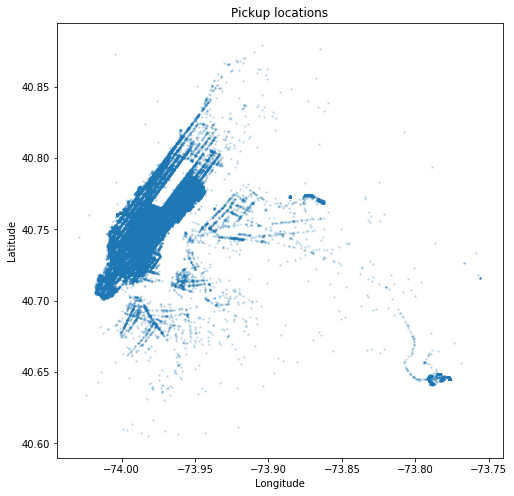

In [3]:
def pickup_scatter(t):
    plt.scatter(t['pickup_lon'], t['pickup_lat'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(all_taxi)

The two small blobs outside of Manhattan with very high concentrations of taxi pick-ups are airports.

### I. 3) Selection of Data

We create a DataFrame called `clean_taxi` that only includes trips with a positive passenger count, a positive distance, a duration of at least 1 minute and at most 1 hour, and an average speed of at most 100 miles per hour. 

In [4]:
all_taxi['average_speed'] = all_taxi['distance'] / (all_taxi['duration']/3600)
all_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,average_speed
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981,14.642202
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320,22.837500
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299,8.428094
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343,8.396501
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470,7.429787


In [5]:
clean_taxi = all_taxi.loc[ (all_taxi['passengers'] >0) & 
                          (all_taxi['distance']>0) & 
                         (all_taxi['duration'] >= 60) & 
                          (all_taxi['duration'] <= 3600) &
                         (all_taxi['average_speed'] <= 100),
                          :]

clean_taxi = clean_taxi.drop('average_speed', axis = 1)
clean_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470


### I. 4) Taxis in Manhattan

We create a DataFrame called `manhattan_taxi` that only includes trips from `clean_taxi` that start and end within a polygon that defines the boundaries of [Manhattan Island](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488).

The vertices of this polygon are defined in `manhattan.csv` as (latitude, longitude) pairs, which are [published here](https://gist.github.com/baygross/5430626).

An efficient way to test if a point is contained within a polygon is [described on this page](http://alienryderflex.com/polygon/). 
To check if our code is working, we will draw a scatter diagram of the (lon, lat) pairs of the result; the scatter diagram should have the shape of Manhattan.

In [8]:
polygon = pd.read_csv('manhattan.csv')
polygon.head()

,lat,lon
0,40.700292,-74.010773
1,40.707580,-73.999271
2,40.710443,-73.978758
3,40.721762,-73.971977
4,40.729568,-73.971291


In [9]:
# We first develop and test a function that takes a position and returns whether or not it's in Manhattan.

def in_manhattan(x, y):
    """Whether a longitude-latitude (x, y) pair is in the Manhattan polygon."""
    lat = list(polygon['lat'])
    lon = list(polygon['lon'])
    
    j = len(lat) - 1
    oddNodes = False
    
    for i in range(0, j+1):
        if ((lat[i] < y <= lat[j]) or (lat[j] < y <= lat[i])) and (lon[i] <= x or lon[j] <= x):
            if (lon[i] + (y - lat[i]) / (lat[j] - lat[i]) * (lon[j] - lon[i])) < x:
                oddNodes = not oddNodes
        j = i
    
    return oddNodes

In [10]:
# Then, we apply this function to every trip to filter clean_taxi.

manhattan_taxi = clean_taxi.copy()

manhattan_taxi['drop_off_Manhattan'] = clean_taxi.apply(lambda x: in_manhattan(x.dropoff_lon, x.dropoff_lat), axis=1)
manhattan_taxi['pickup_Manhattan'] = clean_taxi.apply(lambda x: in_manhattan(x.pickup_lon, x.pickup_lat), axis=1)

manhattan_taxi = manhattan_taxi.loc[ (manhattan_taxi['drop_off_Manhattan'] == True) &
                                    (manhattan_taxi['pickup_Manhattan'] == True), :]

manhattan_taxi = manhattan_taxi.drop('drop_off_Manhattan', axis = 1)
manhattan_taxi = manhattan_taxi.drop('pickup_Manhattan', axis = 1)

In [11]:
manhattan_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812


A scatter diagram of only Manhattan taxi rides has the familiar shape of Manhattan Island. 

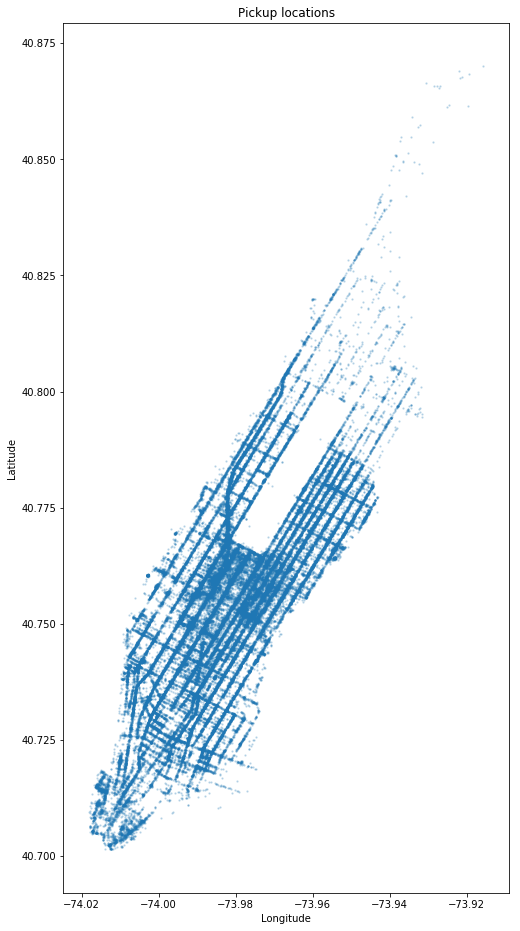

In [13]:
plt.figure(figsize=(8, 16))
pickup_scatter(manhattan_taxi)

### I. 5) Summary

We print a summary of the data selection and cleaning we performed. 


In [14]:
all_rows, clean_rows, man_rows = [t.shape[0] for t in [all_taxi, clean_taxi, manhattan_taxi]]
cleaned = all_rows - clean_rows
cleaned_percentage = str((cleaned / all_rows) * 100)[:3]
print(f"Of the original {all_rows} trips, {cleaned} anomolous trips ({cleaned_percentage}%) "
      f"were removed through data cleaning, and then the {man_rows} trips within Manhattan "
       "were selected for further analysis.")

Of the original 97692 trips, 1247 anomolous trips (1.2%) were removed through data cleaning, and then the 82800 trips within Manhattan were selected for further analysis.


---
# Part II - Exploratory Data Analysis

In this part, we'll choose which days to include as training data in our regression model. 

Our goal is to develop a general model that could potentially be used for future taxi rides. There is no guarantee that future distributions will resemble observed distributions, but some effort to limit training data to typical examples can help ensure that the training data are representative of future observations.

January 2016 had some atypical days. New Years Day (January 1) fell on a Friday. MLK Day was on Monday, January 18. A [historic blizzard](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard) passed through New York that month. Using this dataset to train a general regression model for taxi trip times must account for these unusual phenomena, and one way to account for them is to remove atypical days from the training data.

### II. 1) Date

We first add a column labeled `date` to `manhattan_taxi` that contains the date (but not the time) of pickup, formatted as a `datetime.date` value ([docs](https://docs.python.org/3/library/datetime.html#date-objects)). 

In [15]:
manhattan_taxi['date'] = pd.to_datetime(manhattan_taxi['pickup_datetime']).dt.date
manhattan_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981,2016-01-30
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320,2016-01-04
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299,2016-01-07
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470,2016-01-08
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812,2016-01-02


### II. 2) Visualization of the blizzard

We create a data visualization that allows us to identify which dates were affected by the historic blizzard of January 2016. 

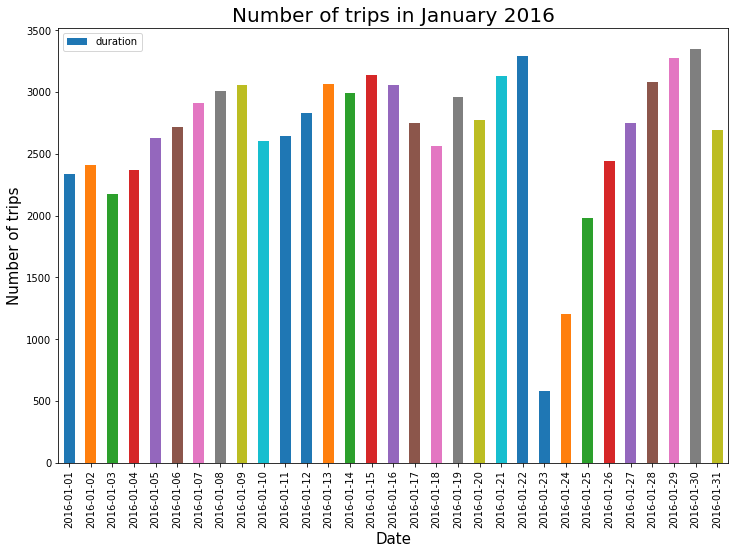

In [16]:
df = manhattan_taxi.groupby('date').count().reset_index()

df.plot(kind = 'bar', x = 'date', y = 'duration', figsize = (12,8))
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of trips', fontsize = 15)
plt.title('Number of trips in January 2016', fontsize = 20)
plt.show()

Finally, we have generated a list of dates that should have a fairly typical distribution of taxi rides, which excludes holidays and blizzards. The cell below assigns `final_taxi` to the subset of `manhattan_taxi` that is on these days.

In [17]:
import calendar
import re

from datetime import date

atypical = [1, 2, 3, 18, 23, 24, 25, 26]
typical_dates = [date(2016, 1, n) for n in range(1, 32) if n not in atypical]
typical_dates

print('Typical dates:\n')
pat = '  [1-3]|18 | 23| 24|25 |26 '
print(re.sub(pat, '   ', calendar.month(2016, 1)))

final_taxi = manhattan_taxi[manhattan_taxi['date'].isin(typical_dates)]

Typical dates:

    January 2016
Mo Tu We Th Fr Sa Su
                    
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
   19 20 21 22      
      27 28 29 30 31



# Part III - Feature Engineering

In this part, we'll create a design matrix (i.e., feature matrix) for our linear regression model. We decide to predict trip duration from the following inputs: start location, end location, trip distance, time of day, and day of the week (*Monday, Tuesday, etc.*). 

We will ensure that the process of transforming observations into a design matrix is expressed as a Python function called `design_matrix`, so that it's easy to make predictions for different samples in later parts of the project.

Because we are going to look at the data in detail in order to define features, it's best to split the data into training and test sets now, then only inspect the training set.

In [18]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(final_taxi, train_size=0.8, test_size=0.2, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)

Train: (53680, 10) Test: (13421, 10)


### III. 1) Duration

We create a box plot that compares the distributions of taxi trip durations for each day **using `train` only**. 

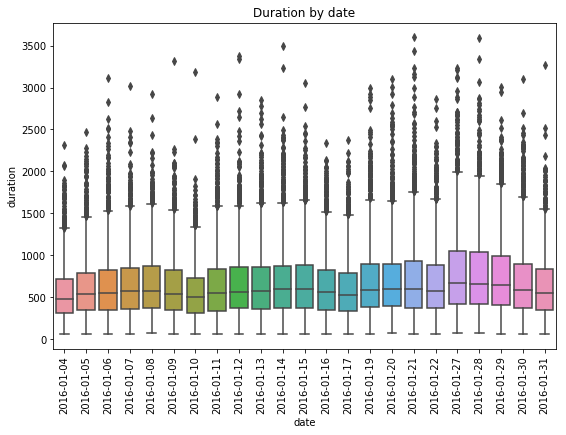

In [19]:
data = train.sort_values('date')

plt.figure(figsize=(9, 6))
sns.boxplot('date', 'duration', data = data);
plt.xticks(rotation=90);
plt.title('Duration by date');

**Remarks**: 

At least in the first two weeks, the duration upper quartile increases throughout the week from Monday to Friday, dips on Saturday, dips a lot on Sunday, then increases for the next Monday. The last week doesn't follow this pattern as clearly, perhaps because of residual effects of the blizzard. 

### III. 2) Augment Function

Below, the `augment` function adds various columns to a taxi ride dataframe. 

- `hour`: The integer hour of the pickup time. E.g., a 3:45pm taxi ride would have `15` as the hour. A 12:20am ride would have `0`.
- `day`: The day of the week with Monday=0, Sunday=6.
- `weekend`: 1 if and only if the `day` is Saturday or Sunday.
- `period`: 1 for early morning (12am-6am), 2 for daytime (6am-6pm), and 3 for night (6pm-12pm).
- `speed`: Average speed in miles per hour.

In [20]:
def speed(t):
    """Return a column of speeds in miles per hour."""
    return t['distance'] / t['duration'] * 60 * 60

def augment(t):
    """Augment a dataframe t with additional columns."""
    u = t.copy()
    pickup_time = pd.to_datetime(t['pickup_datetime'])
    u.loc[:, 'hour'] = pickup_time.dt.hour
    u.loc[:, 'day'] = pickup_time.dt.weekday
    u.loc[:, 'weekend'] = (pickup_time.dt.weekday >= 5).astype(int)
    u.loc[:, 'period'] = np.digitize(pickup_time.dt.hour, [0, 6, 18])
    u.loc[:, 'speed'] = speed(t)
    return u
    
train = augment(train)
test = augment(test)

In [21]:
train.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date,hour,day,weekend,period,speed
16548,2016-01-21 18:02:20,2016-01-21 18:27:54,-73.994202,40.751019,-73.963692,40.771069,1,2.77,1534,2016-01-21,18,3,0,3,6.500652
10750,2016-01-29 06:18:36,2016-01-29 06:21:32,-73.990402,40.756344,-73.984161,40.761757,3,0.69,176,2016-01-29,6,4,0,2,14.113636
10957,2016-01-04 20:34:21,2016-01-04 20:42:33,-74.006554,40.732922,-74.001175,40.751366,1,1.60,492,2016-01-04,20,0,0,3,11.707317
89932,2016-01-09 12:12:58,2016-01-09 12:20:26,-73.992065,40.750313,-73.982803,40.755829,1,0.90,448,2016-01-09,12,5,1,2,7.232143
54687,2016-01-13 10:57:45,2016-01-13 11:02:06,-73.959358,40.771824,-73.964661,40.770443,1,0.40,261,2016-01-13,10,2,0,2,5.517241


### III. 3) Average speed

We use `sns.distplot` to create an overlaid histogram comparing the distribution of average speeds for taxi rides that start in the early morning (12am-6am), day (6am-6pm; 12 hours), and night (6pm-12am; 6 hours). 

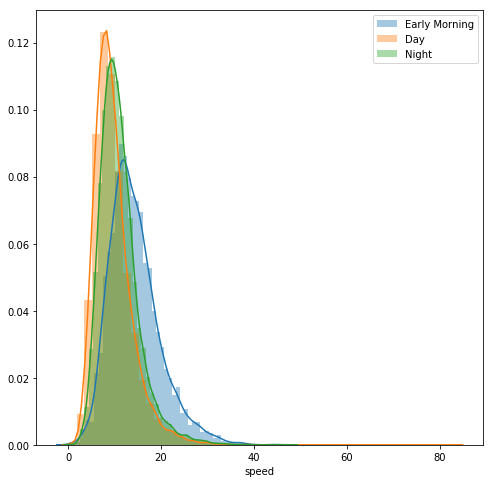

In [22]:
plt.figure(figsize=(8,8))
sns.distplot(train.loc[ train['period'] == 1, 'speed'], kde=True, label = 'Early Morning')
sns.distplot(train.loc[ train['period'] == 2, 'speed'], kde=True, label = 'Day')
sns.distplot(train.loc[ train['period'] == 3, 'speed'], kde=True, label = 'Night')
plt.legend()
plt.show();

It looks like the time of day is associated with the average speed of a taxi ride.

### III. 4) Regions of Manhattan

Manhattan can roughly be divided into Lower, Midtown, and Upper regions. Instead of studying a map, let's approximate by finding the first principal component of the pick-up location (latitude and longitude). 

We add a `region` column to `train` that categorizes each pick-up location as 0, 1, or 2 based on the value of each point's first principal component, such that an equal number of points fall into each region. 

Here is the documentation of [`pd.qcut`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.qcut.html), which categorizes points in a distribution into equal-frequency bins.

In [23]:
# Find the first principle component
D = train[['pickup_lon', 'pickup_lat']].values
pca_n = D.shape[0]
pca_means = np.mean(D, axis=0) 
X = (D - pca_means) / np.sqrt(pca_n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """Add a region column to t based on vt above."""
    D = t[['pickup_lon', 'pickup_lat']].values
    assert D.shape[0] == t.shape[0], 'We set D using the incorrect table'
    # Always use the same data transformation used to compute vt
    X = (D - pca_means) / np.sqrt(pca_n) 
    first_pc = X @ vt.T[:,0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
    
add_region(train)
add_region(test)

In [24]:
train.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date,hour,day,weekend,period,speed,region
16548,2016-01-21 18:02:20,2016-01-21 18:27:54,-73.994202,40.751019,-73.963692,40.771069,1,2.77,1534,2016-01-21,18,3,0,3,6.500652,1
10750,2016-01-29 06:18:36,2016-01-29 06:21:32,-73.990402,40.756344,-73.984161,40.761757,3,0.69,176,2016-01-29,6,4,0,2,14.113636,1
10957,2016-01-04 20:34:21,2016-01-04 20:42:33,-74.006554,40.732922,-74.001175,40.751366,1,1.60,492,2016-01-04,20,0,0,3,11.707317,0
89932,2016-01-09 12:12:58,2016-01-09 12:20:26,-73.992065,40.750313,-73.982803,40.755829,1,0.90,448,2016-01-09,12,5,1,2,7.232143,1
54687,2016-01-13 10:57:45,2016-01-13 11:02:06,-73.959358,40.771824,-73.964661,40.770443,1,0.40,261,2016-01-13,10,2,0,2,5.517241,2


Let's see how PCA divided the trips into three groups. These regions do roughly correspond to Lower Manhattan (below 14th street), Midtown Manhattan (between 14th and the park), and Upper Manhattan (bordering Central Park). 

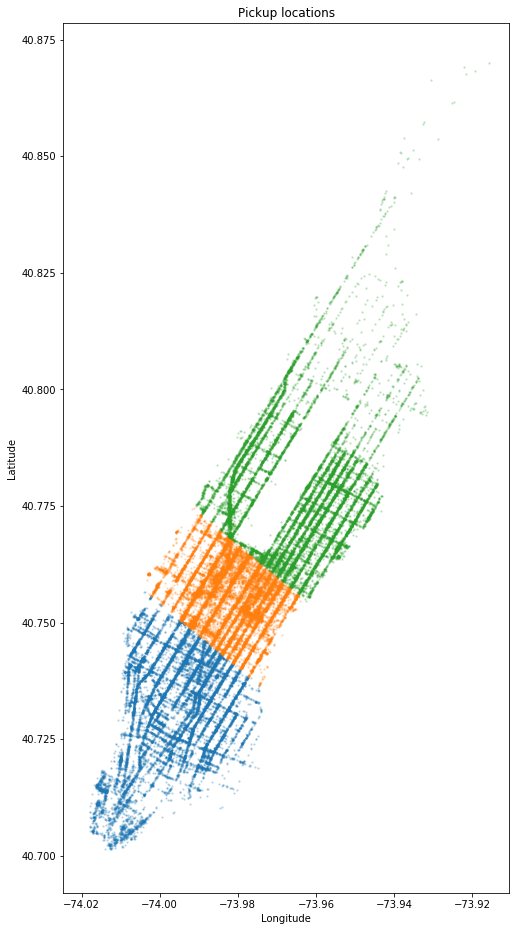

In [25]:
plt.figure(figsize=(8, 16))
for i in [0, 1, 2]:
    pickup_scatter(train[train['region'] == i])

### III. 5) Nighttime taxi rides

We use `sns.distplot` to create an overlaid histogram comparing the distribution of speeds for nighttime taxi rides (6pm-12am) in the three different regions defined above. Does it appear that there is an association between region and average speed during the night?

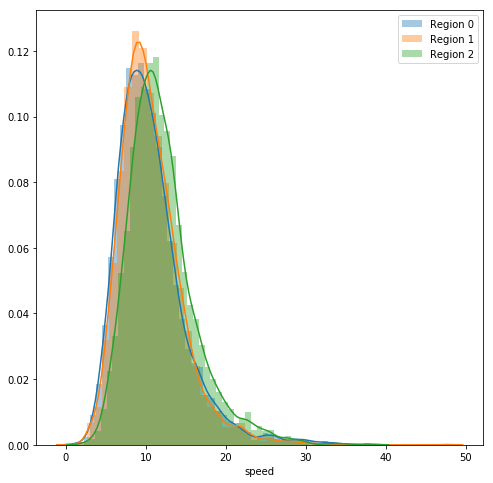

In [26]:
plt.figure(figsize=(8,8))
sns.distplot(train.loc[ (train['region'] == 0) & (train['period'] == 3), 'speed'], kde=True, label = 'Region 0')
sns.distplot(train.loc[ (train['region'] == 1) & (train['period'] == 3), 'speed'], kde=True, label = 'Region 1')
sns.distplot(train.loc[ (train['region'] == 2) & (train['period'] == 3), 'speed'], kde=True, label = 'Region 2')
plt.legend()
plt.show();

### III. 6) Design Matrix

Finally, we create a design matrix that includes many of these features. Quantitative features are converted to standard units, while categorical features are converted to dummy variables using one-hot encoding. The `period` is not included because it is a linear combination of the `hour`. The `weekend` variable is not included because it is a linear combination of the `day`.  The `speed` is not included because it was computed from the `duration`; it's impossible to know the speed without knowing the duration, given that you know the distance.

In [27]:
from sklearn.preprocessing import StandardScaler

num_vars = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
cat_vars = ['hour', 'day', 'region']

scaler = StandardScaler()
scaler.fit(train[num_vars])

def design_matrix(t):
    """Create a design matrix from taxi ride dataframe t."""
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    categoricals = [pd.get_dummies(t[s], prefix=s, drop_first=True) for s in cat_vars]
    return pd.concat([scaled] + categoricals, axis=1)

design_matrix(train).iloc[0,:]  

pickup_lon    -0.805821
pickup_lat    -0.171761
dropoff_lon    0.954062
dropoff_lat    0.624203
distance       0.626326
hour_1         0.000000
hour_2         0.000000
hour_3         0.000000
hour_4         0.000000
hour_5         0.000000
hour_6         0.000000
hour_7         0.000000
hour_8         0.000000
hour_9         0.000000
hour_10        0.000000
hour_11        0.000000
hour_12        0.000000
hour_13        0.000000
hour_14        0.000000
hour_15        0.000000
hour_16        0.000000
hour_17        0.000000
hour_18        1.000000
hour_19        0.000000
hour_20        0.000000
hour_21        0.000000
hour_22        0.000000
hour_23        0.000000
day_1          0.000000
day_2          0.000000
day_3          1.000000
day_4          0.000000
day_5          0.000000
day_6          0.000000
region_1       1.000000
region_2       0.000000
Name: 16548, dtype: float64

---
# Part IV - Model Selection

In this part, we will select a regression model to predict the duration of a taxi ride.

### IV. 1) Constant Model

We assign `constant_rmse` to the root mean squared error on the test set for a constant model that always predicts the mean duration of all training set taxi rides.

In [28]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

constant_model = np.mean(train['duration']) - test['duration']

constant_rmse = rmse(constant_model)
constant_rmse

399.1437572352677

### IV. 2) Simple Linear Model

We assign `simple_rmse` to the root mean squared error on the test set for a simple linear regression model that uses only the distance of the taxi ride as a feature (and includes an intercept).

*Terminology Note*: Simple linear regression means that there is only one covariate. Multiple linear regression means that there is more than one.

In [29]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

X_train = train[['distance']]
Y_train = train['duration']
X_test = test[['distance']]
Y_test = test['duration']

model.fit(X_train, Y_train)
predictions = model.predict(X_test)
errors = predictions - Y_test

simple_rmse = rmse(errors) 
simple_rmse

276.78411050003365

### IV. 3) Linear Regression Model

We assign `linear_rmse` to the root mean squared error on the test set for a linear regression model fitted to the training set without regularization, using the design matrix defined by the `design_matrix` function from Part 3.

In [30]:
model = LinearRegression()

X_train = design_matrix(train)
Y_train = train['duration']
X_test = design_matrix(test)
Y_test = test['duration']

model.fit(X_train, Y_train)
predictions = model.predict(X_test)
errors = predictions - Y_test

linear_rmse = rmse(errors)
linear_rmse

255.19146631882796

### IV. 4) Unregularized Linear Regression Model

For each possible value of `period`, we fit an unregularized linear regression model to the subset of the training set in that `period`.  We assign `period_rmse` to the root mean squared error on the test set for a model that first chooses linear regression parameters based on the observed period of the taxi ride, then predicts the duration using those parameters. Again, we fit to the training set and use the `design_matrix` function for features.

In [31]:
model = LinearRegression()

errors = []

for v in np.unique(train['period']):
    period_train = train.loc[ train['period']==v , : ]
    period_test = test.loc[ test['period']==v , : ]
    
    design_train = design_matrix(period_train)
    design_test = design_matrix(period_test)

    X_train = design_train
    Y_train = train.loc[ train['period']==v , 'duration' ]
    X_test = design_test
    Y_test = test.loc[ test['period']==v , 'duration' ]
    
    model.fit(X_train, Y_train)
    predictions = np.array(model.predict(X_test))

    eps = ((predictions - Y_test).values).tolist()
    
    errors = errors + eps

period_rmse = rmse(np.array(errors))
period_rmse

246.62868831165176

This approach is a simple form of decision tree regression, where a different regression function is estimated for each possible choice among a collection of choices. In this case, the depth of the tree is only 1.

**Remarks**: Linear regression can only model linear associations. There must be an assocation between period, other covariates, and duration that is non-linear. An example is that speed (which is the slope of distance) varies by period, but a linear model with the provided design matrix cannot express this interaction.

### IV. 5) Predicting Average Speed

Instead of predicting duration directly, an alternative is to predict the average *speed* of the taxi ride using linear regression, then compute an estimate of the duration from the predicted speed and observed distance for each ride.

We assign `speed_rmse` to the root mean squared error in the **duration** predicted by a model that first predicts speed as a linear combination of features from the `design_matrix` function, fitted on the training set, then predicts duration from the predicted speed and observed distance.

*Note*: Speed is in miles per hour, but duration is measured in seconds. We'll need the fact that there are 60 * 60 = 3,600 seconds in an hour.

In [32]:
model = LinearRegression()

design_train = design_matrix(train)
design_test = design_matrix(test)

X_train = design_train
Y_train = train['speed']
X_test = design_test
Y_test = test['speed']

model.fit(X_train, Y_train)
predictions_speed = np.array(model.predict(X_test))

predictions_duration = (test['distance'] * 3600) / predictions_speed 

speed_rmse = rmse(predictions_duration - test['duration'])
speed_rmse

243.01798368514963

### IV. 6) Tree Regression Model

Finally, we build the function `tree_regression_errors` (and helper function `speed_error`) that combines the ideas from the two previous models and generalizes to multiple categorical variables.

The `tree_regression_errors` will:
- Find a different linear regression model for each possible combination of the variables in `choices`;
- Fit to the specified `outcome` (on train) and predict that `outcome` (on test) for each combination (`outcome` will be `'duration'` or `'speed'`);
- Use the specified `error_fn` (either `duration_error` or `speed_error`) to compute the error in predicted duration using the predicted outcome;
- Aggregate those errors over the whole test set and return them.

We will find that including each of `period`, `region`, and `weekend` improves prediction accuracy, and that predicting speed rather than duration leads to more accurate duration predictions.

In [33]:
model = LinearRegression()

choices = ['period', 'region', 'weekend']

def duration_error(predictions, observations):
    """Error between predictions (array) and observations (data frame)"""
    return predictions - observations['duration']

def speed_error(predictions, observations):
    """Duration error between speed predictions and duration observations"""
    predictions_duration = (observations['distance'] * 3600) / predictions
    return predictions_duration - observations['duration']

def tree_regression_errors(outcome='duration', error_fn=duration_error):
    """Return errors for all examples in test using a tree regression model."""
    
    errors = []
    
    for vs in train.groupby(choices).size().index:
        v_train, v_test = train, test
        for v, c in zip(vs, choices):
            v_train = v_train.loc[ v_train[c] == v, :]
            v_test = v_test.loc[ v_test[c] == v, :]
    
        design_train = design_matrix(v_train)
        design_test = design_matrix(v_test)
        
        X_train = design_train
        Y_train = v_train.loc[ : , outcome ]
        X_test = design_test
        Y_test = v_test.loc[ : , outcome ]
        
        model.fit(X_train, Y_train)
        predictions = np.array(model.predict(X_test))

        eps = error_fn(predictions,v_test).tolist()
    
        errors = errors + eps
            
    return errors

errors = tree_regression_errors()
errors_via_speed = tree_regression_errors('speed', speed_error)

tree_rmse = rmse(np.array(errors))
tree_speed_rmse = rmse(np.array(errors_via_speed))

print('Duration:', tree_rmse, '\nSpeed:', tree_speed_rmse)

Duration: 240.3395219270353 
Speed: 226.90793945018314


### IV. 7) Summary

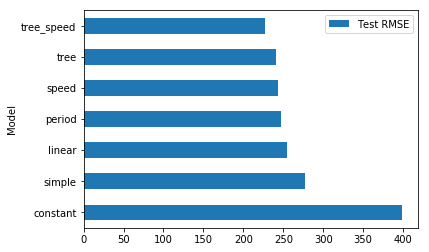

In [34]:
models = ['constant', 'simple', 'linear', 'period', 'speed', 'tree', 'tree_speed']
pd.DataFrame.from_dict({
    'Model': models,
    'Test RMSE': [eval(m + '_rmse') for m in models]
}).set_index('Model').plot(kind='barh');

---
# Conclusion

We've carried out the entire data science lifecycle for a challenging regression problem. 

In Part 1 on data selection, we solved a domain-specific programming problem relevant to the analysis when choosing only those taxi rides that started and ended in Manhattan.

In Part 2 on EDA, we used the data to assess the impact of a historical event---the 2016 blizzard---and filtered the data accordingly.

In Part 3 on feature engineering, we used PCA to divide up the map of Manhattan into regions that roughly corresponded to the standard geographic description of the island.

In Part 4 on model selection, we found that using linear regression in practice can involve more than just choosing a design matrix. Tree regression made better use of categorical variables than linear regression. The domain knowledge that duration is a simple function of distance and speed allowed us to predict duration more accurately by first predicting speed.

Hopefully, it is apparent that all of these steps are required to reach a reliable conclusion about what inputs and model structure are helpful in predicting the duration of a taxi ride in Manhattan. 

---
# Future Work

Here are some questions to ponder:

- The regression model would have been more accurate if we had used the date itself as a feature instead of just the day of the week. Why didn't we do that?
- Does collecting this information about every taxi ride introduce a privacy risk? The original data also included the total fare; how could someone use this information combined with an individual's credit card records to determine their location?
- Why did we treat `hour` as a categorical variable instead of a quantitative variable? Would a similar treatment be beneficial for latitude and longitude?
- Why are Google Maps estimates of ride time much more accurate than our estimates?


Here are some possible extensions to the project:

- An alternative to throwing out atypical days is to condition on a feature that makes them atypical, such as the weather or holiday calendar. 
- Training a different linear regression model for every possible combination of categorical variables can overfit. How would we select which variables to include in a decision tree instead of just using them all?
- Our models use the observed distance as an input, but the distance is only observed after the ride is over. How could we estimate the distance from the pick-up and drop-off locations?
- How would we incorporate traffic data into the model?